In [23]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [24]:
np.random.seed(2)

# Read the dataset

In [25]:
data = pd.read_csv('chinese_mnist.csv', low_memory = False)
# Internally process the file in chunks, resulting in lower memory use while parsing, 
# but possibly mixed type inference. To ensure no mixed types, set False, 
data.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [28]:
IMAGE_PATH = "MNIST/data/"
print("dataframe rows:", data.shape[0]) 
print("image files :", len(os.listdir(IMAGE_PATH)))

dataframe rows: 15000
image files : 15000


In [29]:
def file_path_col(data):    
    file_path = f"input_{data[0]}_{data[1]}_{data[2]}.jpg"
    return file_path

data["file_path"] = data.apply(file_path_col, axis = 1)
data.head()

,suite_id,sample_id,code,value,character,file_path
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


In [30]:
data.groupby(["value","character"]).size()

value      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
dtype: int64

In [52]:
data.isnull().sum()

suite_id     0
sample_id    0
code         0
value        0
character    0
file_path    0
dtype: int64

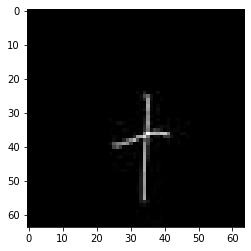

In [68]:

path = os.path.join(IMAGE_PATH, data['file_path'][1*1000])
path_img = imread(path)
plt.imshow(path_img, cmap='gray')

# split the dataset into training data and testing data

In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=0, stratify=data["code"].values, shuffle = True)

print(train.shape[0])
print(test.shape[0])

12000
3000


In [54]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=0, stratify=train["code"].values, shuffle = True)

In [55]:
print(f"Train set rows: {train.shape[0]}")
print(f"Test set rows: {test.shape[0]}")
print(f"Val set rows: {val_data.shape[0]}")

Train set rows: 12000
Test set rows: 3000
Val set rows: 2400


In [56]:
import skimage.io
import skimage.transform

def read_image(file_name):
    path = os.path.join(IMAGE_PATH, file_name)
    
    image = skimage.io.imread(path)
    image = skimage.transform.resize(image, (64, 64, 1), mode='reflect')
    
    return image[:,:,:]

def character_encoder(dataset, var='character'):
    X = np.stack(dataset['file_path'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [57]:
X_train, y_train = character_encoder(train)
X_val, y_val = character_encoder(val_data)
X_test, y_test = character_encoder(test)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(12000, 64, 64, 1) , (12000, 15)
(2400, 64, 64, 1) , (2400, 15)
(3000, 64, 64, 1) , (3000, 15)


In [58]:
X_train[1]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [62]:
y_train

,一,七,万,三,九,二,五,亿,八,六,十,千,四,百,零
4229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9061,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4491,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1302,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10231,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12124,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13026,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8577,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=X_train.shape[1:], padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Conv2D(164, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 164)         2

# Train the model

In [17]:
history = model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
94/94 [==============================] - 165s 2s/step - loss: 2.1759 - accuracy: 0.2685 - val_loss: 0.4133 - val_accuracy: 0.8687
Epoch 2/25
94/94 [==============================] - 157s 2s/step - loss: 0.4758 - accuracy: 0.8380 - val_loss: 0.2586 - val_accuracy: 0.9038
Epoch 3/25
94/94 [==============================] - 162s 2s/step - loss: 0.2223 - accuracy: 0.9248 - val_loss: 0.1142 - val_accuracy: 0.9663
Epoch 4/25
94/94 [==============================] - 141s 2s/step - loss: 0.1638 - accuracy: 0.9457 - val_loss: 0.0580 - val_accuracy: 0.9858
Epoch 5/25
94/94 [==============================] - 145s 2s/step - loss: 0.1035 - accuracy: 0.9672 - val_loss: 0.0642 - val_accuracy: 0.9821
Epoch 6/25
94/94 [==============================] - 151s 2s/step - loss: 0.0806 - accuracy: 0.9771 - val_loss: 0.0364 - val_accuracy: 0.9879
Epoch 7/25
94/94 [==============================] - 145s 2s/step - loss: 0.0561 - accuracy: 0.9799 - val_loss: 0.0288 - val_accuracy: 0.9929
Epoch 8/25
94

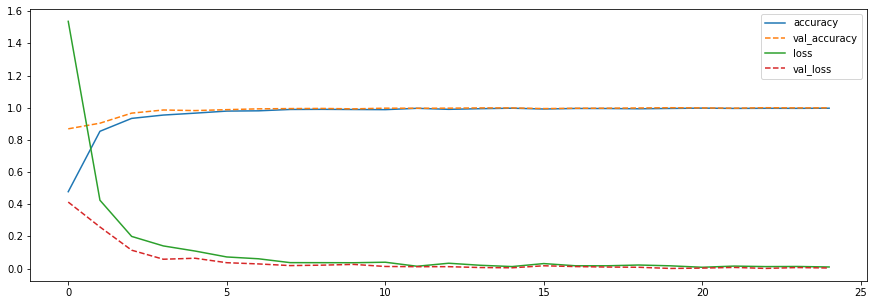

In [18]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()

# Test the model

In [19]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print(f'Test Loss is {ModelLoss}')
print(f'Test Accuracy is {ModelAccuracy}')

94/94 [==============================] - 7s 69ms/step - loss: 0.0163 - accuracy: 0.9953
Test Loss is 0.016291052103042603
Test Accuracy is 0.9953333139419556


In [20]:
columns_names=y_test.columns
print(list(columns_names))

character_value=data.groupby(["value","character"]).size()
dic_df=dict(character_value)
dic_l=list(dic_df.keys())
dic_v=[i[0] for i in dic_l]
dic_k=[i[1] for i in dic_l]
dic=dict(zip(dic_k, dic_v))
print(dic)

['一', '七', '万', '三', '九', '二', '五', '亿', '八', '六', '十', '千', '四', '百', '零']
{'零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10, '百': 100, '千': 1000, '万': 10000, '亿': 100000000}


In [21]:
!pip install pyplotz

  Created wheel for pyplotz: filename=pyplotz-0.24-py3-none-any.whl size=3666 sha256=7c422315f94c1e76aea18bd9ee7ace36e34379a7584b7ad95b0dd905096f124d
  Stored in directory: /Users/sunrongsheng/Library/Caches/pip/wheels/1c/8b/b3/1d220e9a69877287002efbf7b95f06c303a4c93c03c5ad4a3f
Successfully built pyplotz


try downloading
start downloading default chinese font(only for first time)
downloading complete
Font installed at the first time


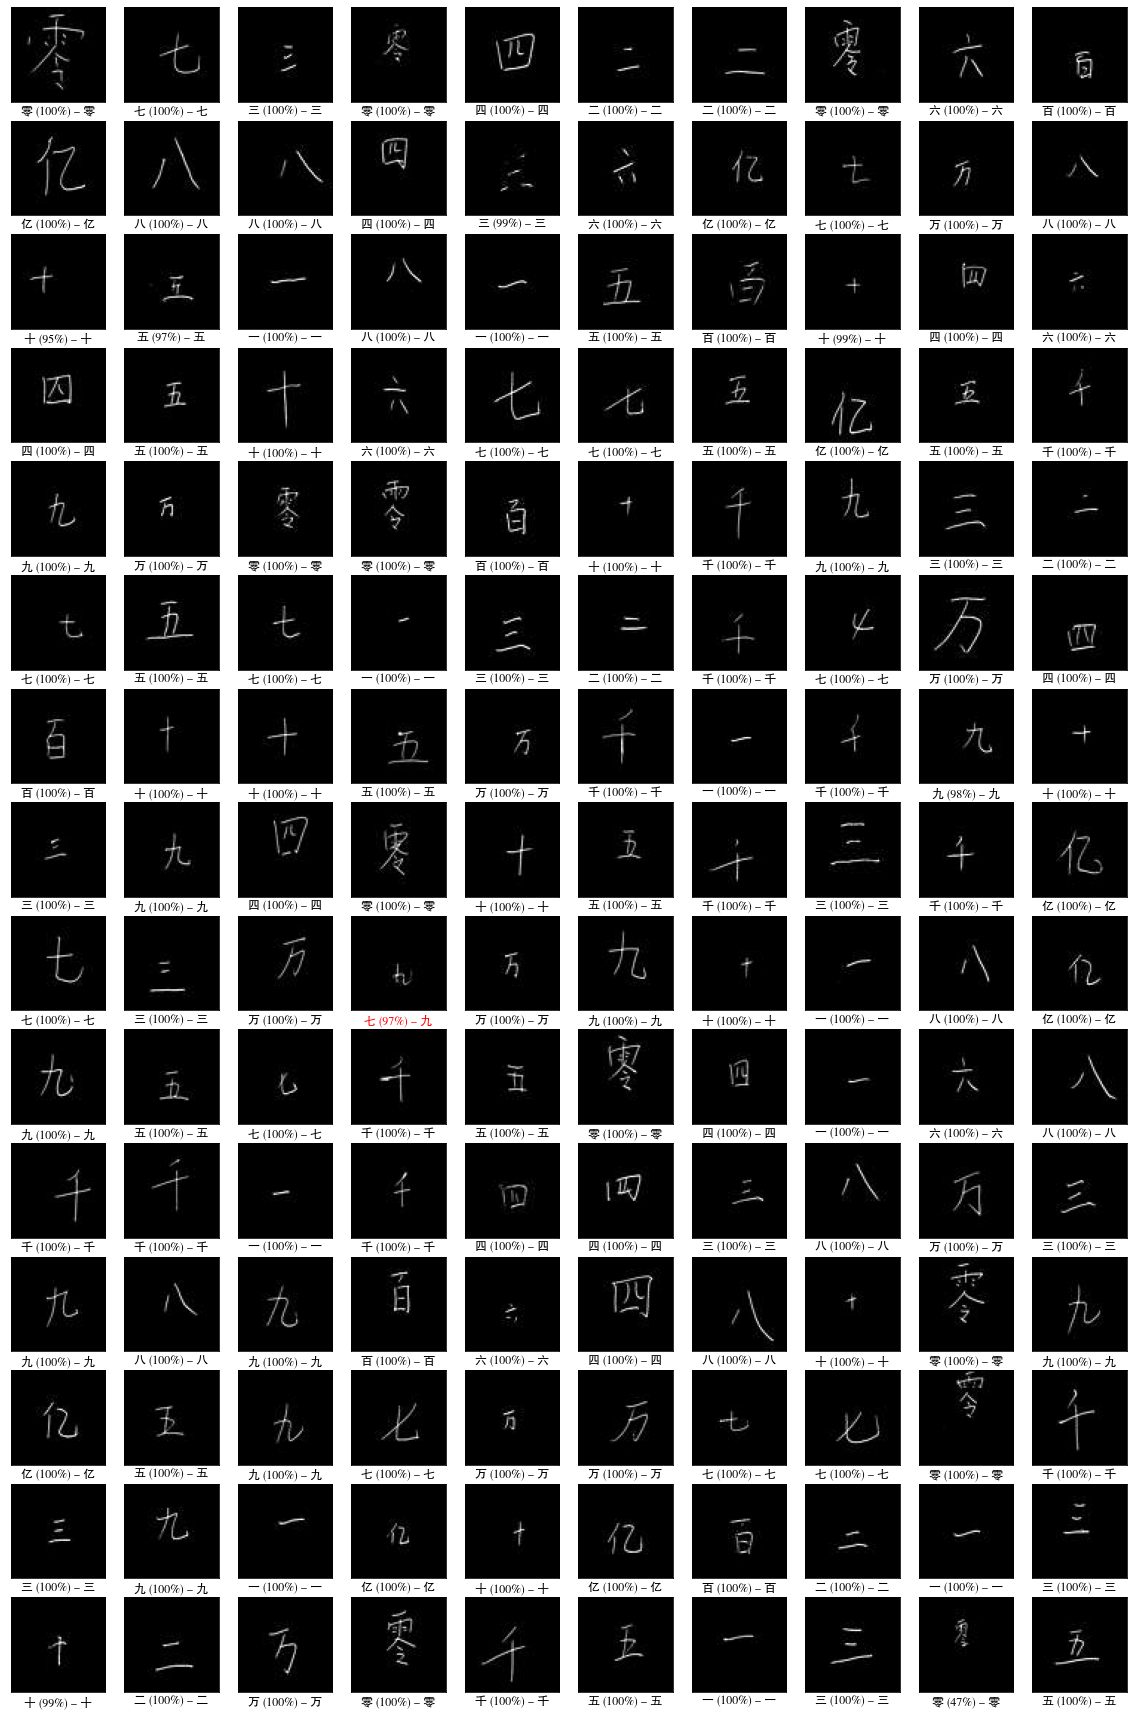

In [22]:
from pyplotz.pyplotz import PyplotZ
pltz = PyplotZ()
pltz.enable_chinese()

predict=model.predict(X_test)

plt.figure(figsize=(20, 31))
for i in range(150):
    
    predicted_label = np.argmax(predict[i])

    row=y_test.iloc[i, :].values.tolist()
    true_label = np.argmax(row)

    columns_names=list(y_test.columns)
    
    color='black'
    if predicted_label!=true_label:
        color='red'
    
    plt.subplot(15, 10, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pltz.xlabel(f"{columns_names[predicted_label]} ({100*predict[i][predicted_label]:2.0f}%) - {columns_names[true_label]}",
                fontsize=12, color=color)
    plt.xticks([])
    plt.yticks([])